In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import s3fs
import scipy
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

sys.path.append("/Users/fgu/dev/projects/entropy")
import entropy.data.aggregators as ag
import entropy.data.cleaners as cl
import entropy.data.make_data as md
import entropy.data.selectors as sl
import entropy.data.validators as vl
import entropy.helpers.aws as ha
import entropy.helpers.data as hd
import entropy.helpers.helpers as hh

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.set_option("max_colwidth", None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
%matplotlib widget

fs = s3fs.S3FileSystem(profile="3di")

## Load data

In [117]:
dfa = hd.read_analysis_data("XX7")

Time for read_analysis_data            : 3.52 seconds


In [3]:
dfs = hd.read_txn_data("777")

Time for read_txn_data                 : 2.08 seconds


## e and es component correlation

Calculate entropies and components

$es = \sum_{cat > 0}\frac{f_i + 1}{N + Cz + Cnz}log(\frac{f_i + 1}{N + Cz + Cnz}) + Cz \times - \frac{1}{N + Cz + Cnz}log(\frac{1}{N + Cz + Cnz})$, where $N$ is number of transactions, and $Cz$ and $Cnz$ are number of categories with zero and non-zero counts, respectively. Below, I refer to lhs as A and to rhs as B.

In [104]:
# Create entropy components
df = pd.DataFrame()

counts = ag._entropy_base_values(data, "tag_spend")
df["N"] = counts.sum(1)
df["Cz"] = counts.eq(0).sum(1)
df["Cnz"] = counts.gt(0).sum(1)
assert all(df.Cz + df.Cnz == len(counts.columns))

denom = df.N + df.Cz + df.Cnz
smooth_probs_pos_counts = (counts > 0) * (counts + 1).div(denom, axis=0)
df["A"] = scipy.special.entr(smooth_probs_pos_counts).sum(1) / np.log(2)

const = -(1 / denom) * np.log2(1 / denom)
df["B"] = df.Cz * const

df["counts_std_all"] = counts.std(1, ddof=0)
df["counts_std_nz"] = counts[counts > 0].std(1, ddof=0)

# Create dataset with components and entropy from analysis data
dfae = dfa.filter(regex="user_id|^ym|entropy_tag_spend(?!.*z)|has_sa_inflows")
df = dfae.merge(df.reset_index(), how="left", validate="1:1")
df = df.set_index(["user_id", "ym"])

# Consistency checks
pd.testing.assert_series_equal(df.A + df.B, df.entropy_tag_spend_s, check_names=False)

df.head(3)

has_sa_inflows  entropy_tag_spend  entropy_tag_spend_s     N  \
user_id ym                                                                      
77      2012-09               1           3.401594             4.980464  50.0   
        2012-10               1           3.007682             4.879649  45.0   
        2012-11               1           3.559940             4.974805  55.0   

                 Cz  Cnz         A         B  counts_std_all  counts_std_nz  
user_id ym                                                                   
77      2012-09  32   15  2.803173  2.177291        2.310054       3.025815  
        2012-10  33   14  2.539676  2.339973        2.782601       4.328949  
        2012-11  29   18  3.077743  1.897062        2.452260       3.152992

In [105]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
has_sa_inflows,9926.0,0.414467,0.492655,0.000000,0.000000,0.000000,1.000000,1.000000
entropy_tag_spend,9926.0,3.205227,0.415776,0.921928,2.951404,3.238584,3.497675,4.452932
entropy_tag_spend_s,9926.0,4.780438,0.316309,3.187717,4.583261,4.809122,5.008545,5.515563
N,9926.0,68.023574,33.777608,4.000000,43.000000,61.000000,86.000000,224.000000
Cz,9926.0,31.377896,4.146772,16.000000,29.000000,32.000000,34.000000,44.000000
Cnz,9926.0,15.622104,4.146772,3.000000,13.000000,15.000000,18.000000,31.000000
A,9926.0,2.769677,0.490793,0.606904,2.457992,2.795322,3.103822,4.243653
B,9926.0,2.010761,0.648464,0.559706,1.529490,1.957414,2.420473,4.893857
counts_std_all,9926.0,3.635974,1.980327,0.279040,2.207543,3.223035,4.624932,16.439967
counts_std_nz,9926.0,5.159860,3.026699,0.000000,2.989726,4.557783,6.643914,29.259165


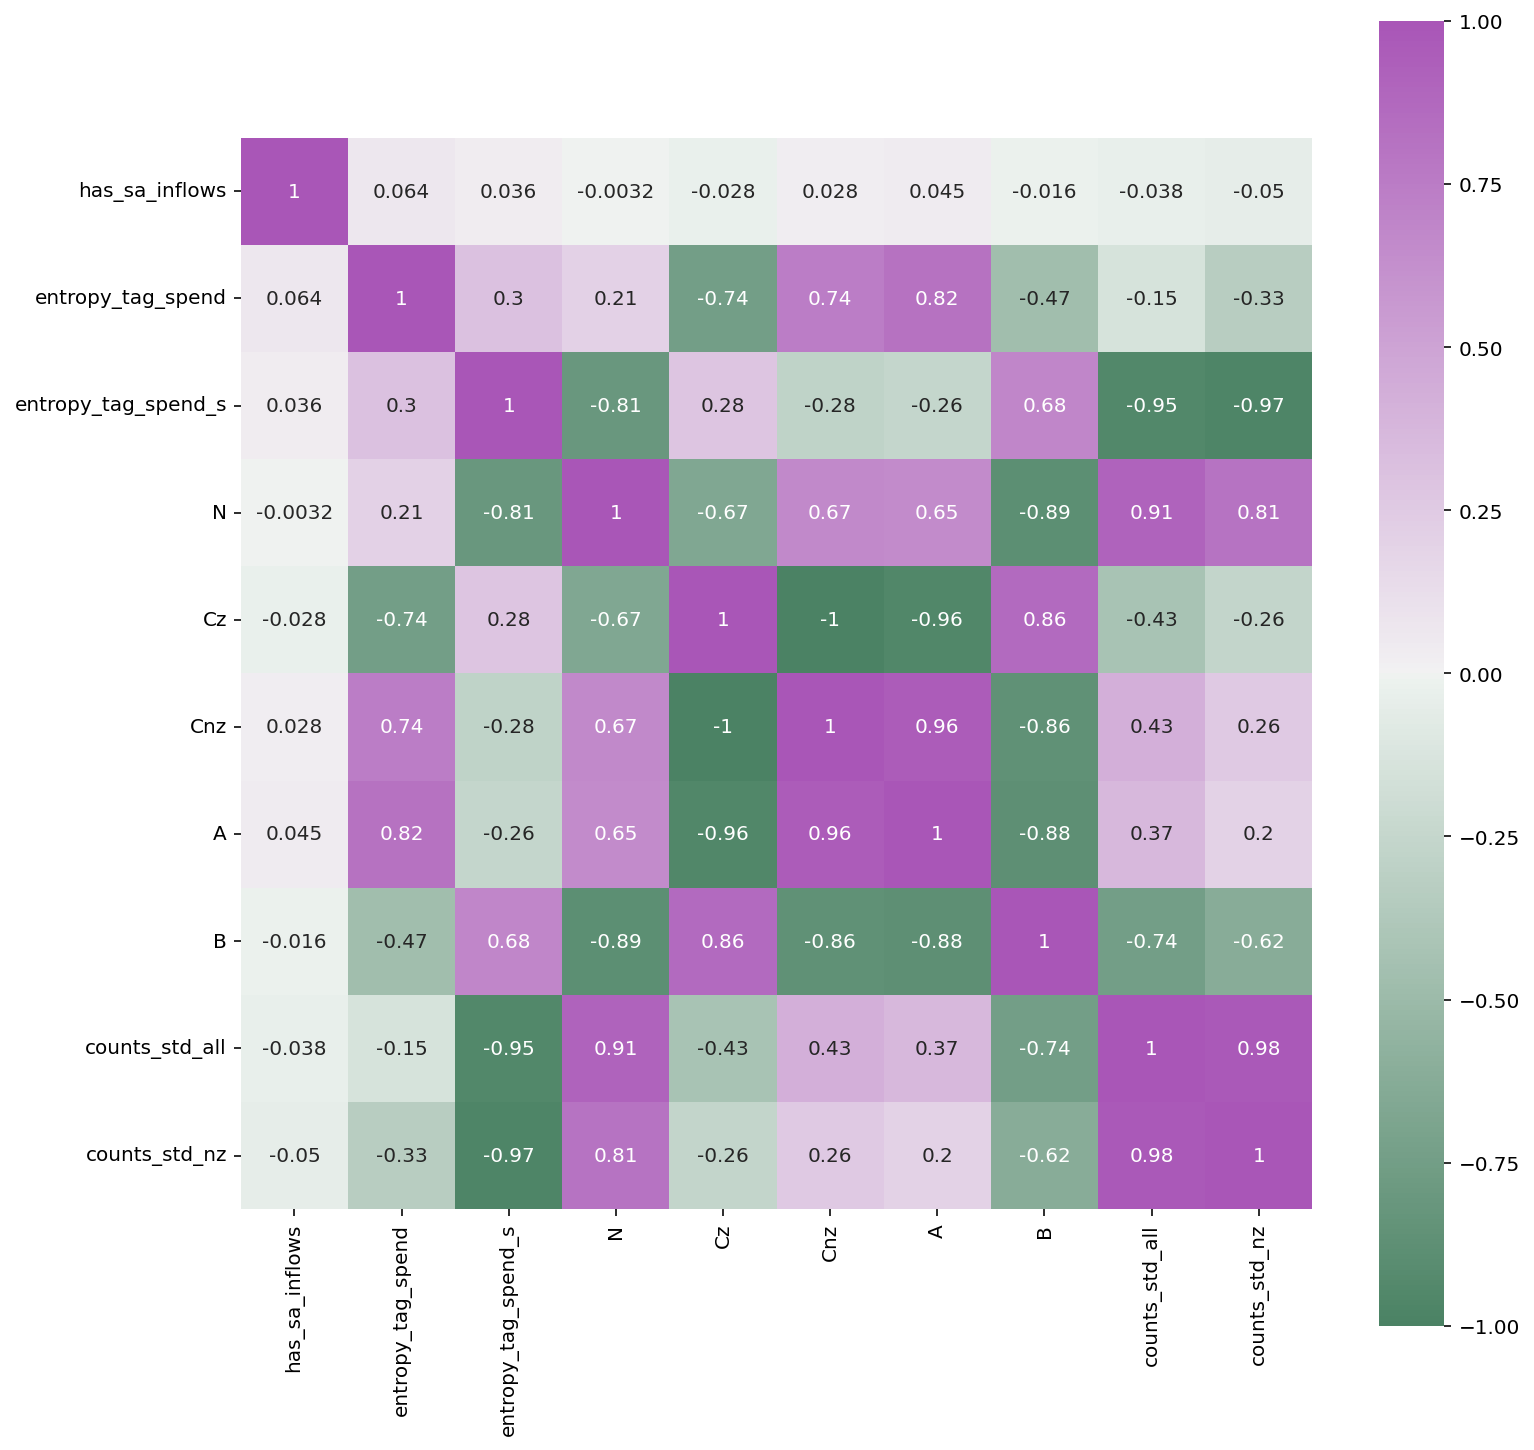

In [106]:
%matplotlib inline
fig = plt.figure(figsize=(12, 12))
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
mask = None
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(corr, mask=mask, square=True, annot=True, cmap=cmap);

In [116]:
dfk = hd.read_analysis_data("X77")
dfk[["entropy_tag_spend", "entropy_tag_spend_s", "has_sa_inflows"]].corr()

Time for read_analysis_data            : 0.69 seconds


,entropy_tag_spend,entropy_tag_spend_s,has_sa_inflows
entropy_tag_spend,1.000000,0.304963,0.063505
entropy_tag_spend_s,0.304963,1.000000,0.036221
has_sa_inflows,0.063505,0.036221,1.000000


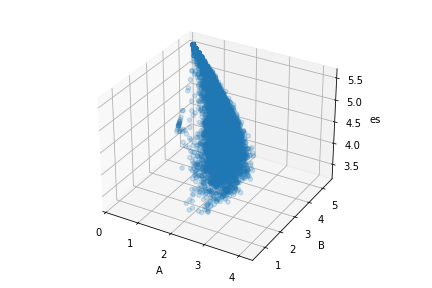

In [49]:
%matplotlib widget
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df.A, df.B, df.es, alpha=0.2)
ax.set(xlabel="A", ylabel="B", zlabel="es")
plt.tight_layout()

## Observations:

- e and A correlate strongly as expected

- es mainly driven by B (since most counts are zero) and actually negatively correlated with A.

## dev

## Do we lack proper data for low entropy users?

High entropy correlates most strongly with the number of zero counts and the total number of spend transactions, and is also positively correlated with a savings transaction. One possibility is that this an artifact of our data: if we don't observe the full transaction history for some users (e.g. because they don't link all their accounts), then these users will tend to have lower entropy and we are less likely to observe a savings transaction.

If this were true, then we'd expect to observe implausibly low total spend txns counts for low entropy users, suggesting that we don't observe all their spend txns.

The below shows that this is not the case: while spend txns are lower for low entropy users (by contruction), they are not implausibly low.

In [60]:
sample = "X77"
dft = hd.read_txn_data(sample)
dfa = hd.read_analysis_data(sample)

Time for read_txn_data                 : 36.05 seconds
Time for read_analysis_data            : 0.92 seconds


Identify low-entropy users

In [61]:
pct = 5
entropy_pct = np.percentile(dfa.entropy_tag_spend, pct)
entropy_user_mean = dfa.groupby("user_id").entropy_tag_spend.mean()
is_low_entropy_user = (entropy_user_mean <= entropy_pct).rename("low_entropy_user")

Count spend txns by user

In [65]:
is_spend_txn = dft.tag_group.eq("spend") & dft.is_debit
spend = dft[is_spend_txn]
user_month_counts = spend.groupby(["user_id", "ym"]).size().groupby("user_id").median()
user_month_counts.head(3)

user_id
77     31.0
177    74.0
277    52.0
dtype: float64

Do user-month counts differ by entropy?

In [66]:
user_month_counts.groupby(is_low_entropy_user).describe().T

low_entropy_user,False,True
count,366.000000,11.000000
mean,63.087432,43.954545
std,32.488974,20.662108
min,5.000000,11.000000
25%,40.000000,31.000000
50%,57.000000,43.000000
75%,79.750000,60.000000
max,206.000000,74.000000


## dev

In [126]:
dfa

,user_id,ym,txns_count,txns_volume,txns_count_spend,txns_count_sa,txns_count_ca,nunique_tag,nunique_tag_spend,nunique_merchant,pct_credit,month_income_effective,month_income,year_income,income_var,has_month_income,age,is_female,sa_inflows,sa_outflows,sa_netflows,has_sa_inflows,has_reg_sa_inflows,has_benefits,has_pension,has_rent_pmt,has_mortgage_pmt,has_loan_funds,has_loan_repmt,region_name,is_urban,has_od_fees,month_spend,spend_tag_services,spend_tag_other_spend,spend_tag_household,spend_tag_travel,spend_tag_communication,spend_tag_finance,spend_tag_motor,spend_tag_retail,spend_tag_hobbies,spend_tag_spend_vehicle,spend_tag_spend_cash,spend_tag_spend_groceries,spend_tag_spend_public_transport,spend_tag_spend_phone_and_mobile,spend_tag_spend_bank_charges,spend_tag_spend_household,spend_tag_spend_entertainment,spend_tag_spend_eating_out,"spend_tag_spend_entertainment,_tv,_media",spend_tag_spend_appliances,spend_tag_spend_financial,spend_tag_spend_clothes_and_shoes,spend_tag_spend_home,spend_tag_spend_personal_care,spend_tag_spend_administration,spend_tag_spend_energy_and_water,spend_tag_spend_reading,spend_tag_spend_holidays,spend_tag_spend_taxes,spend_tag_spend_flowers,spend_tag_spend_gifts,spend_tag_spend_insurance,spend_tag_spend_charity,spend_tag_spend_alcohol,spend_tag_spend_legal,spend_tag_spend_sports,spend_tag_spend_office,spend_tag_spend_hobbies,spend_tag_spend_flights,spend_tag_spend_health_care,spend_tag_spend_diy,spend_tag_spend_business_expenses,spend_tag_spend_gambling,spend_tag_spend_housing,spend_tag_spend_jewellery,spend_tag_spend_taxi,spend_tag_spend_loan_repayment,spend_tag_spend_garden,spend_tag_spend_children,spend_tag_spend_pet,spend_tag_spend_education,spend_tag_spend_vehicle_hire,spend_tag_spend_childcare,spend_tag_spend_art,spend_tag_spend_accessories,spend_tag_spend_fines,entropy_tag,entropy_tag_z,entropy_tag_s,entropy_tag_sz,ssd_tag,entropy_tag_spend,entropy_tag_spend_z,entropy_tag_spend_s,entropy_tag_spend_sz,ssd_tag_spend,entropy_merchant,entropy_merchant_z,entropy_merchant_s,entropy_merchant_sz,ssd_merchant,entropy_groc,entropy_groc_z,entropy_groc_s,entropy_groc_sz
0,37,2012-04,17.0,5654.799805,8,1.0,9.0,3,5,3,4.855317,0.44000,1.564053,18.768633,0.623895,1,27.0,0.0,1500.0,0.000000,1500.000000,1,0,0,0,0,1,0,0,scotland,0.0,0,1.20816,0.05866,0.62331,0.52619,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.62331,0.17861,0.0,0.00000,0.000,0.00798,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0000,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.05068,0.00000,0.0,0.000,0.34758,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.561278,-0.979345,2.866587,1.014205,14.888889,2.155639,-0.875887,5.440362,1.432497,14.638298,1.584963,-1.815369,10.083279,0.911932,2.991713,0.000000,-2.076207,4.297079,1.142271
1,37,2012-05,20.0,5678.870117,14,1.0,13.0,4,5,5,14.387589,1.30853,1.564053,18.768633,0.523057,1,27.0,0.0,0.0,2848.500000,-2848.500000,0,0,0,0,0,1,0,0,scotland,0.0,0,0.62401,0.02447,0.05324,0.48099,0.00000,0.06531,0.00000,0.00000,0.00000,0.00000,0.00000,0.05324,0.13341,0.0,0.05000,0.000,0.00000,0.0,0.00000,0.03978,0.00000,0.0,0.00000,0.00000,0.0000,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0,0.000,0.34758,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.664498,-0.792623,2.662954,0.250701,54.222222,1.921185,-1.173707,5.262624,0.970552,59.829787,1.780672,-1.624232,10.069009,0.679353,55.867403,0.591673,-1.333431,3.952981,-0.196891
2,37,2012-06,20.0,2395.929932,14,0.0,11.0,5,7,7,28.576956,1.45486,1.564053,18.768633,0.475645,1,27.0,0.0,0.0,0.000000,0.000000,0,0,0,0,0,1,0,0,scotland,0.0,0,0.72387,0.02757,0.09300,0.42401,0.00000,0.06531,0.00000,0.00000,0.11398,0.00000,0.00000,0.09300,0.07643,0.0,0.05000,0.000,0.00399,0.0,0.00000,0.03889,0.00000,0.0,0.11398,0.00000,0.0000,0.0,0.00000,0.00000,0.0,0.00000,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,0.0

In [122]:
dft = hd.read_txn_data("777")

Time for read_txn_data                 : 2.79 seconds


In [133]:
def month_cat_spend(df):
    is_spend = df.tag_group.eq("spend") & df.is_debit
    tag_names = df.tag_spend.cat.rename_categories(
        lambda x: "count_" + x.replace(" ", "_")
    )
    return is_spend.groupby([df.user_id, df.ym, tag_names]).sum().unstack()


k = month_cat_spend(dft)